In [156]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt 
from scipy import stats

# Load Data (ZRI, ACS) 

In [175]:
zri = pd.read_csv('../data/zri_multifamily_v2.csv')
zri['zip'] = zri['zip'].astype('string')
zri['zip'] = ["0"+z if len(z)<5 else z for z in zri['zip']]
zri['year'] = pd.to_datetime(zri['year-month'],format="%Y-%m").dt.year
zri['year'] = zri['year'].astype('string')
zri['year-month'] = pd.to_datetime(zri['year-month'],format="%Y-%m")
zri = zri.drop(index=zri[zri['zip']=="11249"].index)

In [176]:
acs = pd.read_csv('../data/acs_engineered_features.csv')
acs['zip'] = acs['zip'].astype('string')
acs['zip'] = ["0"+z if len(z)<5 else z for z in acs['zip']]
acs['year_usable'] = acs['year_usable'].astype('string')

#  ZRI Data - target variable - zscore(zri), log(zri) 

<AxesSubplot:>

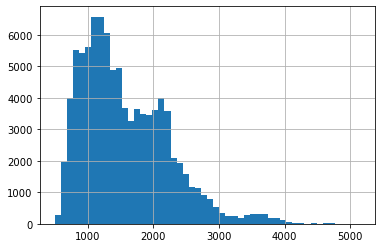

In [159]:
zri['zri'].hist(bins=50)

<AxesSubplot:>

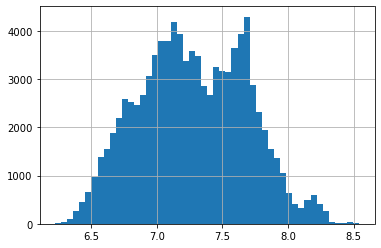

In [160]:
np.log(zri['zri']).hist(bins=50)

In [161]:
pd.Series(stats.zscore(zri[zri['zip']=='07302']['zri']))

0    -1.985107
1    -1.985107
2    -2.074549
3    -2.098942
4    -2.025762
        ...   
67    1.454330
68    1.576296
69    1.625082
70    1.673868
71    1.673868
Length: 72, dtype: float64

In [162]:
zri[zri['zip']=='07302']['zri']

14256    2135.0
14257    2135.0
14258    2124.0
14259    2121.0
14260    2130.0
          ...  
14323    2558.0
14324    2573.0
14325    2579.0
14326    2585.0
14327    2585.0
Name: zri, Length: 72, dtype: float64

In [163]:
zri['zri_zscore'] = zri['zri']

In [164]:
for z in zri['zip'].unique():
    zri.loc[zri['zip']==z,'zri_zscore'] = stats.zscore(zri.loc[zri['zip']==z,'zri'])

<AxesSubplot:>

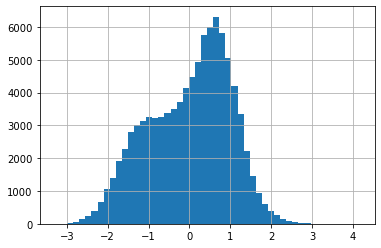

In [165]:
zri['zri_zscore'].hist(bins=50)

<AxesSubplot:>

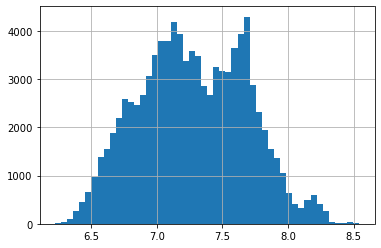

In [166]:
np.log(zri['zri']).hist(bins=50)

In [177]:
zillow = zri[['zip','City','State','year-month','year','zri']]

In [178]:
zillow

,zip,City,State,year-month,year,zri
0,01013,Chicopee,MA,2014-01-01,2014,928.0
1,01013,Chicopee,MA,2014-02-01,2014,931.0
2,01013,Chicopee,MA,2014-03-01,2014,934.0
3,01013,Chicopee,MA,2014-04-01,2014,929.0
4,01013,Chicopee,MA,2014-05-01,2014,929.0
...,...,...,...,...,...,...
93739,99654,Wasilla,AK,2019-08-01,2019,1277.0
93740,99654,Wasilla,AK,2019-09-01,2019,1271.0
93741,99654,Wasilla,AK,2019-10-01,2019,1299.0
93742,99654,Wasilla,AK,2019-11-01,2019,1261.5


# Add lagged columns
- ZRI lags: last 3 months
- ACS lags: 12 months before, 24 months before 

In [179]:
# zillow_lags = pd.DataFrame()
# for z in zillow['zip'].unique():
#     data_temp = zillow[zillow['zip']==z]
#     data_temp.loc[:,'zri_lag_1']= data_temp.loc[:,'zri'].shift(+1)
#     data_temp.loc[:,'zri_lag_2']= data_temp.loc[:,'zri'].shift(+2)
#     data_temp.loc[:,'zri_lag_3']= data_temp.loc[:,'zri'].shift(+3)
#     zillow_lags = zillow_lags.append(data_temp)
# zillow_lags[zillow_lags.isna().any(axis=1)]

In [180]:
def laggenerator(i,colname,df):
    timelist=list(df['year-month'].drop_duplicates().sort_values())[0:i]
    
    df.loc[:,f'{colname}_lag{i}']=df.loc[:,f'{colname}'].shift(i)
    
    df.loc[df['year-month'].isin(timelist),f'{colname}_lag{i}']=0
    return df

In [185]:
zillow_lags = zillow.copy()
for i in range(1,4):
    zillow_lags=laggenerator(i, 'zri',zillow_lags)

In [186]:
zillow_lags

,zip,City,State,year-month,year,zri,zri_lag1,zri_lag2,zri_lag3
0,01013,Chicopee,MA,2014-01-01,2014,928.0,0.0,0.0,0.0
1,01013,Chicopee,MA,2014-02-01,2014,931.0,928.0,0.0,0.0
2,01013,Chicopee,MA,2014-03-01,2014,934.0,931.0,928.0,0.0
3,01013,Chicopee,MA,2014-04-01,2014,929.0,934.0,931.0,928.0
4,01013,Chicopee,MA,2014-05-01,2014,929.0,929.0,934.0,931.0
...,...,...,...,...,...,...,...,...,...
93739,99654,Wasilla,AK,2019-08-01,2019,1277.0,1291.0,1294.0,1296.0
93740,99654,Wasilla,AK,2019-09-01,2019,1271.0,1277.0,1291.0,1294.0
93741,99654,Wasilla,AK,2019-10-01,2019,1299.0,1271.0,1277.0,1291.0
93742,99654,Wasilla,AK,2019-11-01,2019,1261.5,1299.0,1271.0,1277.0


In [188]:
acs

,zip,census_period,year_usable,percent_white,percent_black,percent_asian,percent_hispanic,percent_native_am,percent_other_race,percent_0_17,...,median_building_age,income_per_capita,poverty_rate,total_pop,percent_workforce_unemployed,percent_work_from_home,median_age,percent_female,gini_index,percent_not_us_citizen
0,01013,20072011,2013,0.729579,0.020723,0.013756,0.218793,0.000000,0.005002,0.230494,...,62.0,20433.0,0.190522,22391,0.104113,0.008853,36.4,0.510250,0.4210,0.055960
1,01013,20082012,2014,0.714417,0.023463,0.013473,0.231235,0.000000,0.004491,0.224682,...,62.0,20940.0,0.201543,21822,0.104320,0.014770,36.6,0.501650,0.4179,0.057190
2,01013,20092013,2015,0.720119,0.027857,0.016777,0.217971,0.001357,0.005065,0.217248,...,66.0,20889.0,0.173591,22113,0.113411,0.012946,35.5,0.506851,0.4110,0.056483
3,01013,20102014,2016,0.713799,0.017445,0.016638,0.237499,0.000538,0.002197,0.221131,...,72.0,21371.0,0.155696,22299,0.115569,0.013701,35.8,0.512669,0.4061,0.050182
4,01013,20112015,2017,0.703894,0.022238,0.018442,0.241627,0.001116,0.001652,0.222336,...,73.0,21477.0,0.169816,22394,0.114075,0.020243,34.9,0.514200,0.4117,0.050013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92647,99901,20092013,2015,0.653872,0.002271,0.063146,0.044026,0.142407,0.002710,0.233756,...,38.0,31563.0,0.101846,13651,0.086316,0.021073,38.7,0.478353,0.3981,0.025493
92648,99901,20102014,2016,0.654374,0.004016,0.061487,0.046444,0.143932,0.000000,0.232584,...,38.0,31487.0,0.114447,13694,0.085095,0.022509,38.8,0.481233,0.4057,0.023952
92649,99901,20112015,2017,0.649705,0.004228,0.073631,0.048334,0.135379,0.001604,0.230079,...,40.0,32010.0,0.121194,13717,0.078951,0.023050,38.7,0.485602,0.4110,0.025953
92650,99901,20122016,2018,0.645762,0.004947,0.076319,0.046126,0.129138,0.005384,0.225609,...,40.0,32671.0,0.108124,13745,0.075428,0.026582,39.2,0.485922,0.4158,0.035504


In [226]:
merged = pd.merge(zillow_lags,acs,how='left',left_on=["zip","year"],right_on=["zip","year_usable"])
#merged.head(36)[['zip','City','year-month','year','percent_white']]

In [229]:
acs_lags = merged.copy()

In [230]:
acs_cols = ['percent_white',
       'percent_black', 'percent_asian', 'percent_hispanic',
       'percent_native_am', 'percent_other_race', 'percent_0_17',
       'percent_18_39', 'percent_40_64', 'percent_65+',
       'percent_rental_units_vacant', 'percent_rental_units_occupied',
       'percent_graduate_deg', 'percent_bachelors', 'percent_associates',
       'percent_highschool', 'percent_less_highschool',
       'percent_commute_public_transport', 'percent_commute_less_30',
       'percent_commute_30_to_59', 'percent_commute_60_to_89',
       'percent_commute_90_more', 'percent_new_city', 'percent_new_unit',
       'percent_units_owner_occupied', 'median_building_age',
       'income_per_capita', 'poverty_rate', 'total_pop',
       'percent_workforce_unemployed', 'percent_work_from_home', 'median_age',
       'percent_female', 'gini_index', 'percent_not_us_citizen']


for col in acs_cols:
    for i in [12,24]:
        acs_lags=laggenerator(i,col,acs_lags)

In [233]:
acs_lags.tail()

,zip,City,State,year-month,year,zri,zri_lag1,zri_lag2,zri_lag3,census_period,...,percent_work_from_home_lag12,percent_work_from_home_lag24,median_age_lag12,median_age_lag24,percent_female_lag12,percent_female_lag24,gini_index_lag12,gini_index_lag24,percent_not_us_citizen_lag12,percent_not_us_citizen_lag24
93667,99654,Wasilla,AK,2019-08-01,2019,1277.0,1291.0,1294.0,1296.0,20132017,...,0.047433,0.042248,33.5,33.2,0.47311,0.474887,0.3974,0.3889,0.016234,0.022725
93668,99654,Wasilla,AK,2019-09-01,2019,1271.0,1277.0,1291.0,1294.0,20132017,...,0.047433,0.042248,33.5,33.2,0.47311,0.474887,0.3974,0.3889,0.016234,0.022725
93669,99654,Wasilla,AK,2019-10-01,2019,1299.0,1271.0,1277.0,1291.0,20132017,...,0.047433,0.042248,33.5,33.2,0.47311,0.474887,0.3974,0.3889,0.016234,0.022725
93670,99654,Wasilla,AK,2019-11-01,2019,1261.5,1299.0,1271.0,1277.0,20132017,...,0.047433,0.042248,33.5,33.2,0.47311,0.474887,0.3974,0.3889,0.016234,0.022725
93671,99654,Wasilla,AK,2019-12-01,2019,1224.0,1261.5,1299.0,1271.0,20132017,...,0.047433,0.042248,33.5,33.2,0.47311,0.474887,0.3974,0.3889,0.016234,0.022725


# Split train and test

In [298]:
acs_lags['year'] = acs_lags['year'].astype(int)

In [299]:
train = acs_lags[acs_lags['year'] < 2019]
test = acs_lags[acs_lags['year']==2019]

In [300]:
train_y = train['zri']
train_X = train.drop(['zri','year-month','year','census_period','year_usable'],axis=1)

test_y = test['zri']
test_X = test.drop(['zri','year-month','year','census_period','year_usable'],axis=1)

In [301]:
train_X

,zip,City,State,zri_lag1,zri_lag2,zri_lag3,percent_white,percent_black,percent_asian,percent_hispanic,...,percent_work_from_home_lag12,percent_work_from_home_lag24,median_age_lag12,median_age_lag24,percent_female_lag12,percent_female_lag24,gini_index_lag12,gini_index_lag24,percent_not_us_citizen_lag12,percent_not_us_citizen_lag24
0,01013,Chicopee,MA,0.0,0.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
1,01013,Chicopee,MA,928.0,0.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
2,01013,Chicopee,MA,931.0,928.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
3,01013,Chicopee,MA,934.0,931.0,928.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
4,01013,Chicopee,MA,929.0,934.0,931.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93655,99654,Wasilla,AK,1332.0,1334.0,1335.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93656,99654,Wasilla,AK,1337.0,1332.0,1334.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93657,99654,Wasilla,AK,1337.0,1337.0,1332.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93658,99654,Wasilla,AK,1335.0,1337.0,1337.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933


# LASSO

In [331]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

### Label Encode Zip, City, State

In [303]:
label_encoder_zip = LabelEncoder()
label_encoder_city = LabelEncoder()
label_encoder_state = LabelEncoder()

In [304]:
train_X['zip'] = label_encoder_zip.fit_transform(train_X['zip'])
train_X['City'] = label_encoder_city.fit_transform(train_X['City'])
train_X['State'] = label_encoder_state.fit_transform(train_X['State'])

In [305]:
test_X['zip'] = label_encoder_zip.transform(test_X['zip'])
test_X['City'] = label_encoder_city.transform(test_X['City'])
test_X['State'] = label_encoder_state.transform(test_X['State'])

In [306]:
set(train_X['zip']) == set(test_X['zip'])

True

### Standard Scaler

In [312]:
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

In [339]:
train_X

,zip,City,State,zri_lag1,zri_lag2,zri_lag3,percent_white,percent_black,percent_asian,percent_hispanic,...,percent_work_from_home_lag12,percent_work_from_home_lag24,median_age_lag12,median_age_lag24,percent_female_lag12,percent_female_lag24,gini_index_lag12,gini_index_lag24,percent_not_us_citizen_lag12,percent_not_us_citizen_lag24
0,0,84,15,0.0,0.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
1,0,84,15,928.0,0.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
2,0,84,15,931.0,928.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
3,0,84,15,934.0,931.0,928.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
4,0,84,15,929.0,934.0,931.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93655,1300,510,0,1332.0,1334.0,1335.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93656,1300,510,0,1337.0,1332.0,1334.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93657,1300,510,0,1337.0,1337.0,1332.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93658,1300,510,0,1335.0,1337.0,1337.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933


In [338]:
train_X_scaled

array([[-1.73072   , -1.18355718, -0.31120377, ..., -1.20353618,
        -1.06048559, -0.8097274 ],
       [-1.73072   , -1.18355718, -0.31120377, ..., -1.20353618,
        -1.06048559, -0.8097274 ],
       [-1.73072   , -1.18355718, -0.31120377, ..., -1.20353618,
        -1.06048559, -0.8097274 ],
       ...,
       [ 1.73072   ,  1.65706001, -1.49389929, ...,  0.50930001,
        -0.8044568 , -0.57071481],
       [ 1.73072   ,  1.65706001, -1.49389929, ...,  0.50930001,
        -0.8044568 , -0.57071481],
       [ 1.73072   ,  1.65706001, -1.49389929, ...,  0.50930001,
        -0.8044568 , -0.57071481]])

In [320]:
lasso = Lasso()
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.05)
grid

{'alpha': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])}

In [321]:
clf = GridSearchCV(lasso, grid, cv=5, n_jobs=-1)

In [322]:
lasso_grid = clf.fit(train_X_scaled,train_y)

In [326]:
lasso_grid.best_params_

{'alpha': 0.9500000000000001}

In [330]:
lasso_grid.best_score_

0.8618713090468478

In [332]:
lasso = lasso_grid.best_estimator_
lasso.fit(train_X_scaled, train_y)

In [384]:
print('LASSO')
print(f'R2: {lasso.score(test_X_scaled,test_y)}')
print(f'RMSE: {sqrt(mean_squared_error(lasso.predict(test_X_scaled),test_y))}')

LASSO
R2: 0.9845364738047435
RMSE: 82.7329513873741


# Feature importances (Non-zero coefficients )

In [385]:
importance = np.abs(lasso.coef_)
feature_names = np.array(train_X.columns.to_list())

In [386]:
feature_importances = pd.DataFrame(feature_names,importance).reset_index()
feature_importances.columns = ['value','feature_names']

In [397]:
feature_importances = feature_importances.sort_values(by='value',ascending=False)
feature_importances = feature_importances.reset_index().drop('index',axis=1)
feature_importances[feature_importances['value']>0]

,value,feature_names
0,4.699045e+02,zri_lag1
1,1.027324e+02,income_per_capita
2,4.594782e+01,zri_lag3
3,3.915815e+01,percent_commute_public_transport
4,3.432331e+01,State
5,2.688647e+01,percent_graduate_deg_lag12
6,2.586958e+01,percent_asian
7,2.566005e+01,percent_rental_units_vacant
8,2.366940e+01,percent_new_unit
9,2.329591e+01,percent_not_us_citizen


In [391]:
sfm = SelectFromModel(lasso).fit(train_X_scaled, train_y)
print("Features selected by SelectFromModel: \n"
      f"{feature_names[sfm.get_support()]}")

Features selected by SelectFromModel: 
['City' 'State' 'zri_lag1' 'zri_lag3' 'percent_white' 'percent_asian'
 'percent_hispanic' 'percent_native_am' 'percent_other_race'
 'percent_0_17' 'percent_40_64' 'percent_rental_units_vacant'
 'percent_graduate_deg' 'percent_bachelors' 'percent_associates'
 'percent_highschool' 'percent_commute_public_transport'
 'percent_commute_less_30' 'percent_commute_30_to_59'
 'percent_commute_90_more' 'percent_new_city' 'percent_new_unit'
 'percent_units_owner_occupied' 'median_building_age' 'income_per_capita'
 'total_pop' 'percent_work_from_home' 'percent_female' 'gini_index'
 'percent_not_us_citizen' 'percent_other_race_lag24'
 'percent_rental_units_vacant_lag12' 'percent_rental_units_vacant_lag24'
 'percent_graduate_deg_lag12' 'percent_graduate_deg_lag24'
 'percent_bachelors_lag12' 'percent_associates_lag24'
 'percent_highschool_lag12' 'percent_commute_public_transport_lag12'
 'percent_commute_60_to_89_lag12' 'percent_commute_90_more_lag24'
 'percent_n

In [392]:
feature_names[sfm.get_support()].shape

(45,)